In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from emtf_algos import *

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

np.random.seed(2026)

logger = get_logger()

import tensorflow as tf
import keras
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt

logger.info('Using cmssw      : {0}'.format(os.environ['CMSSW_VERSION'] if 'CMSSW_VERSION' in os.environ else 'n/a'))
logger.info('Using numpy      : {0}'.format(np.__version__))
logger.info('Using tensorflow : {0}'.format(tf.__version__))
logger.info('Using keras      : {0}'.format(keras.__version__))
logger.info('.. list devices  : {0}'.format(K.get_session().list_devices()))
logger.info('Using matplotlib : {0}'.format(mpl.__version__))

%matplotlib inline

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-requests/2.21.0-pafccj2/lib/python2.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.2) or chardet (2.2.1) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.
[INFO    ] Using cmssw      : CMSSW_10_6_3
[INFO    ] Using numpy      : 1.16.2
[INFO    ] Using tensorflow : 1.6.0
[INFO    ] Using keras      : 2.2.4
[INFO    ] .. list devices  : [_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]
[INFO    ] Using matplotlib : 2.2.4


In [3]:
# Input files

signal = 'signal_add.0.npz'

bkgnd = 'bkgnd_add.0.npz'

In [4]:
# Load input files

def load_signal(f):
  with np.load(f) as loaded:
    out_part = loaded['out_part']
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    out_simhits = RaggedTensorValue(loaded['out_simhits_values'], loaded['out_simhits_row_splits'])
    print('[INFO] out_part: {0} out_hits: {1} out_simhits: {2}'.format(out_part.shape, out_hits.shape, out_simhits.shape))
  return (out_part, out_hits, out_simhits)

def load_bkgnd(f):
  with np.load(f) as loaded:
    out_hits = RaggedTensorValue(loaded['out_hits_values'], loaded['out_hits_row_splits'])
    print('[INFO] out_hits_bkgnd: {0}'.format(out_hits.shape))
  return (out_hits,)

In [5]:
part_arrays, hits_arrays, simhits_arrays = load_signal(signal)
bkghits_arrays, = load_bkgnd(bkgnd)

[INFO] out_part: (1044081, 10) out_hits: (1044081, None, 8) out_simhits: (1044081, None, 8)
[INFO] out_hits_bkgnd: (16289880, None, 8)


In [6]:
# Debug
print(part_arrays[0], hits_arrays[0], simhits_arrays[0])
print(part_arrays[1], hits_arrays[1], simhits_arrays[1])
print(part_arrays[2], hits_arrays[2], simhits_arrays[2])
print(part_arrays[3], hits_arrays[3], simhits_arrays[3])

[ -0.07286745   1.981351     2.1438558   24.857655   -25.86196
   1.2163241    6.3448358   -0.648671     2.           0.        ] [[  0   0  42 667  14  12   0  -1]
 [  0   3  50 804   0  18   0   0]
 [  0   4  51 813   2  18   0  -1]
 [  0   5  52 831   1  18   0   1]
 [  0   6  52 833   0  19   0   1]
 [  0   7  53 840   0  19  19   1]
 [  0   8  53 846   0  19   0   0]] [[  0   0  42 664   0  13   0   0]
 [  0   2  45 724   0  14   0   0]
 [  0   3  50 804   0  17   0   0]
 [  0   4  51 813   0  18   0   0]
 [  0   5  52 828   0  18   0   0]
 [  0   6  52 834   0  19   0   0]
 [  0   7  53 840   0  19   0   0]
 [  0   8  53 845   0  19   0   0]]
[1.6307077e-01 1.5877699e+00 7.2498721e-01 1.7160455e+02 1.0059981e+02
 6.9927592e+00 7.0719070e+01 2.6855508e-02 0.0000000e+00 2.0000000e+00] [[   2    2  151 2408    0   88    0   -1]
 [   2    4  155 2476    3   85    0   -1]
 [   2    5  155 2484    0   84    0   -2]
 [   2    6  157 2510    4   82    0   -1]
 [   2    7  157 2512    0  

In [7]:
# Build images

class Particle(object):
  def __init__(self, part_array):
    self.invpt = part_array[0]
    self.eta = part_array[1]
    self.phi = part_array[2]
    self.vx = part_array[3]
    self.vy = part_array[4]
    self.vz = part_array[5]
    self.d0 = part_array[6]
    self.phi_s = part_array[7]
    self.sector = part_array[8]
    self.zone = part_array[9]

  def get_parameters(self):
    return np.array([self.invpt, self.d0, self.eta, self.phi, self.invpt], dtype=np.float32)

class Hit(object):
  def __init__(self, hit_array):
    self.zone = hit_array[0]
    self.zone_row = hit_array[1]
    self.zone_col = hit_array[2]
    self.emtf_phi = hit_array[3]
    self.emtf_bend = hit_array[4]
    self.emtf_theta = hit_array[5]
    self.emtf_theta_alt = hit_array[6]
    self.emtf_qual = hit_array[7]

  def get_channels(self):
    f0 = 1.0  # valid flag
    f1 = (1.0 * self.emtf_phi / coarse_emtf_strip) - (1.0 * self.zone_col)
    f2 = 1.0 * self.emtf_bend
    return np.array([f0, f1, f2], dtype=np.float32)

def build_image(zone, part_array, hits_array, simhits_array, bkghits_array):
  num_channels = 1 + 2
  num_cols, col_offset = 300, 20  # truncate the first 20 unit
  num_rows = 10
  assert((max_emtf_strip//coarse_emtf_strip) == num_cols + col_offset)

  img = np.zeros((num_rows, num_cols, num_channels), dtype=np.float32)
  img_gt = np.zeros((num_rows, num_cols, num_channels), dtype=np.float32)

  for hit_array in hits_array:
    hit = Hit(hit_array)
    if hit.zone != zone:
      continue
    if hit.zone_col < col_offset:
      continue
    img[hit.zone_row, (hit.zone_col - col_offset)] = hit.get_channels()

  for simhit_array in simhits_array:
    simhit = Hit(simhit_array)
    if simhit.zone != zone:
      continue
    if simhit.zone_col < col_offset:
      continue
    img_gt[simhit.zone_row, (simhit.zone_col - col_offset)] = simhit.get_channels()
  return (img, img_gt)

def build_images(zone, part_arrays, hits_arrays, simhits_arrays, bkghits_arrays, num=-1):
  images = []
  images_gt = []
  params = []

  zipped = zip(part_arrays, hits_arrays, simhits_arrays, bkghits_arrays)

  for (part_array, hits_array, simhits_array, bkghits_array) in zipped:
    if len(images) == num:
      break

    part = Particle(part_array)
    if part.zone != zone:
      continue

    img, img_gt = build_image(zone, part_array, hits_array, simhits_array, bkghits_array)
    images.append(img)
    images_gt.append(img_gt)
    params.append(part.get_parameters())
  return (images, images_gt, params)

In [8]:
zone = 0
num = 100

images, images_gt, params = build_images(zone, part_arrays, hits_arrays, simhits_arrays, bkghits_arrays, num=num)

In [9]:
# Debug
print(len(images), len(images_gt), len(params))
print(images[0].shape, images_gt[0].shape, params[0].shape)
print(np.nonzero(images[0]), np.nonzero(images_gt[0]), params[0])

100 100 100
(10, 300, 3) (10, 300, 3) (5,)
(array([0, 0, 0, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8]), array([22, 22, 22, 30, 30, 31, 31, 31, 32, 32, 32, 32, 32, 33, 33, 33, 33]), array([0, 1, 2, 0, 1, 0, 1, 2, 0, 1, 2, 0, 1, 0, 1, 0, 1])) (array([0, 0, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8]), array([22, 22, 25, 25, 30, 30, 31, 31, 32, 32, 32, 32, 33, 33, 33, 33]), array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1])) [-0.07286745  6.3448358   1.981351    2.1438558  -0.07286745]


In [10]:
# Debug
print(images[0][np.nonzero(images[0][...,0])])
print(images[1][np.nonzero(images[1][...,0])])
print(images[2][np.nonzero(images[2][...,0])])
print(images[3][np.nonzero(images[3][...,0])])

[[ 1.     -0.3125 14.    ]
 [ 1.      0.25    0.    ]
 [ 1.     -0.1875  2.    ]
 [ 1.     -0.0625  1.    ]
 [ 1.      0.0625  0.    ]
 [ 1.     -0.5     0.    ]
 [ 1.     -0.125   0.    ]]
[[ 1.     -0.1875  0.    ]
 [ 1.     -0.25    9.    ]
 [ 1.      0.4375  4.    ]
 [ 1.     -0.5     5.    ]
 [ 1.     -0.375   0.    ]
 [ 1.      0.125   1.    ]
 [ 1.      0.0625  0.    ]]
[[ 1.     -0.375  -7.    ]
 [ 1.      0.0625 -8.    ]
 [ 1.     -0.5    -8.    ]]
[[  1.       0.4375 -20.    ]
 [  1.      -0.3125  -5.    ]
 [  1.      -0.375    0.    ]
 [  1.      -0.5      0.    ]
 [  1.       0.       0.    ]
 [  1.      -0.1875   0.    ]
 [  1.       0.3125   0.    ]]


In [11]:
# Styling
plt.style.use('tdrstyle.mplstyle')

# Color maps
from matplotlib.colors import LinearSegmentedColormap
cdict = {
  'blue' : ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
blue_hot = LinearSegmentedColormap('blue_hot', cdict)

cdict = {
  'blue' : ((0.0, 0.0, 0.0), (0.365079, 0.0, 0.0), (0.746032, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'green': ((0.0, 0.0416, 0.0416), (0.365079, 1.0, 1.0), (1.0, 1.0, 1.0)),
  'red'  : ((0.0, 0.0, 0.0), (0.746032, 0.0, 0.0), (1.0, 1.0, 1.0)),
}
green_hot = LinearSegmentedColormap('green_hot', cdict)

zone_row_labels = [
  ['ME0'  , 'GE1/1', 'ME1/1', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1', 'none' ],
  ['GE1/1', 'ME1/1', 'ME1/2', 'RE1/2', 'GE2/1', 'ME2/1', 'ME3/1', 'RE3/1', 'ME4/1', 'RE4/1'],
  ['ME1/2', 'RE1/2', 'RE2/2', 'ME2/2', 'ME3/2', 'RE3/2', 'ME4/2', 'RE4/2', 'none' , 'none' ],
  ['MB1'  , 'MB2'  , 'MB3'  , 'ME1/3', 'RE1/3', 'RE2/3', 'ME2/2', 'ME3/2', 'RE3/3', 'ME4/2'],
]

In [12]:
# Display image

def display_image(zone, img, cmap=blue_hot, figsize=(10,2)):
  fig, ax = plt.subplots(1, 1, figsize=figsize)
  ax.imshow(img[...,0], origin='lower', interpolation='none', aspect='auto',
            cmap=cmap, vmin=0, vmax=1.6)
  ax.set_yticks(range(len(zone_row_labels[zone])))
  ax.set_yticklabels(zone_row_labels[zone], fontsize=7)
  plt.show()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-matplotlib/2.2.4-pafccj/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


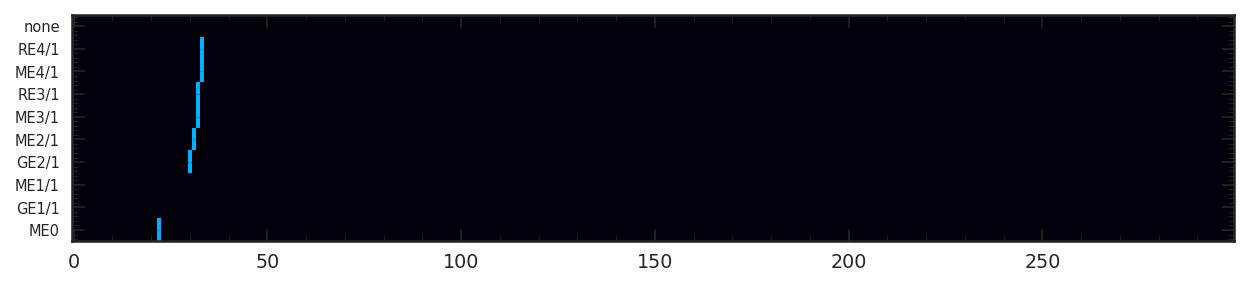

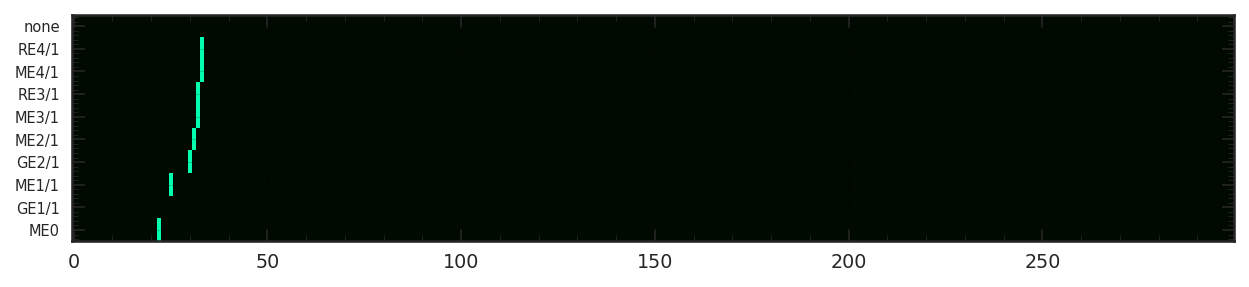

In [13]:
display_image(zone, images[0])
display_image(zone, images_gt[0], cmap=green_hot)

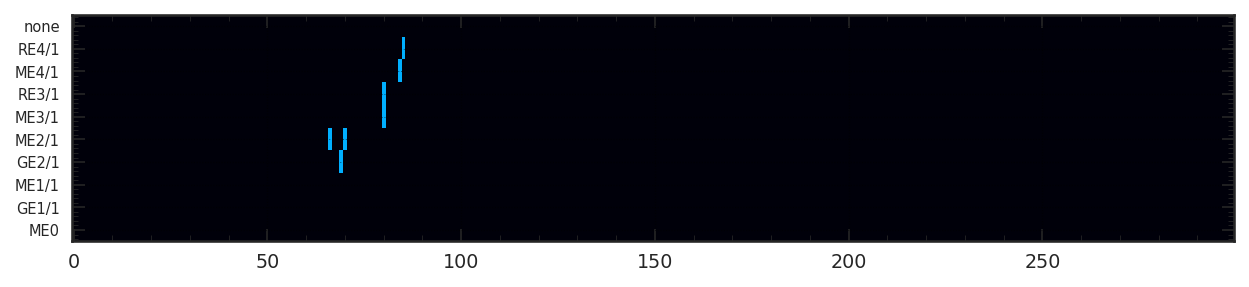

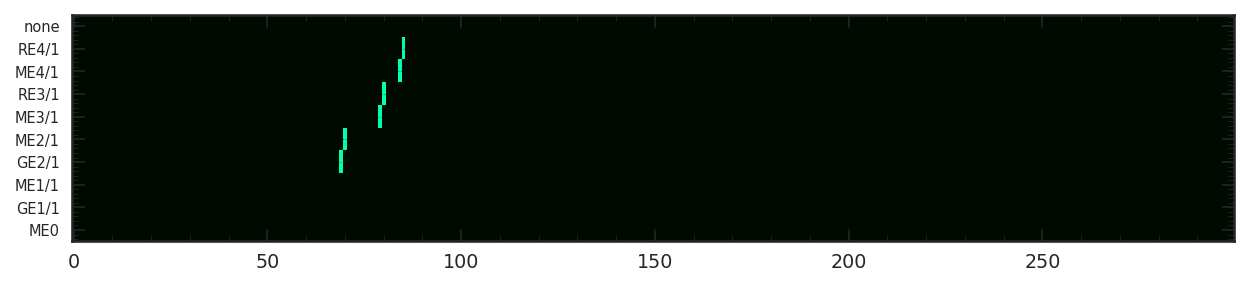

In [14]:
display_image(zone, images[1])
display_image(zone, images_gt[1], cmap=green_hot)

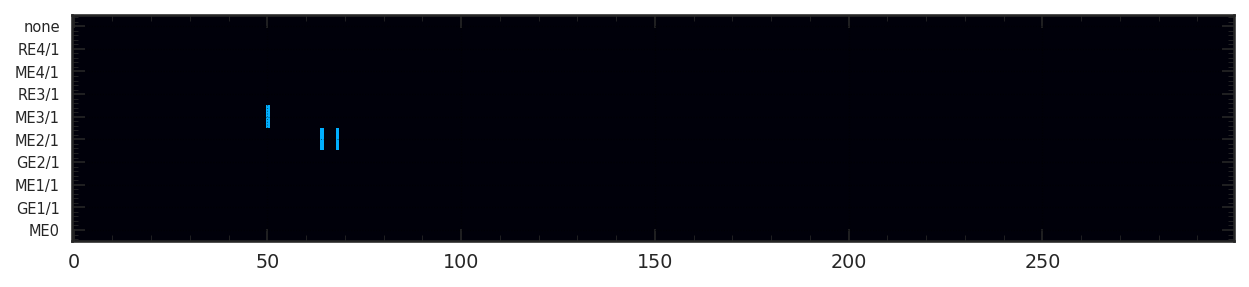

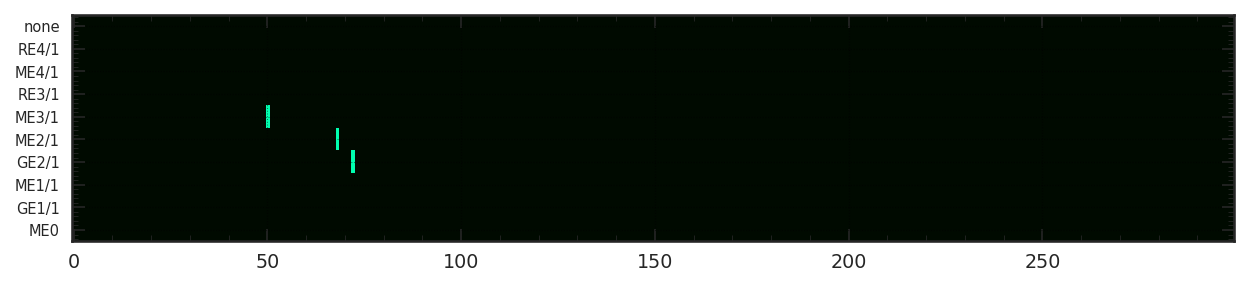

In [15]:
display_image(zone, images[2])
display_image(zone, images_gt[2], cmap=green_hot)